In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
pop = pd.read_csv('GDP and population/canada_population.txt')
GDP = pd.read_csv('GDP and population/canada_gdp.csv')

In [3]:
pop = pop[['Year','Population']]

In [4]:
GDP=GDP.rename(columns={'MKTGDPCAA646NWDB':'GDP'})
GDP=GDP.rename(columns={'DATE':'Year'})

#converting year format to datetime64 for delete month and day, you can check the format with dataframe.info()
GDP['Year'] = pd.to_datetime(GDP['Year'] )
GDP['Year'] = GDP['Year'].dt.strftime('%Y')

# format changing doesn allow us to merge , so we have to conver date format to int
GDP['Year']=GDP['Year'].astype(int)

In [5]:
pop_gdp = pd.merge(GDP,pop)

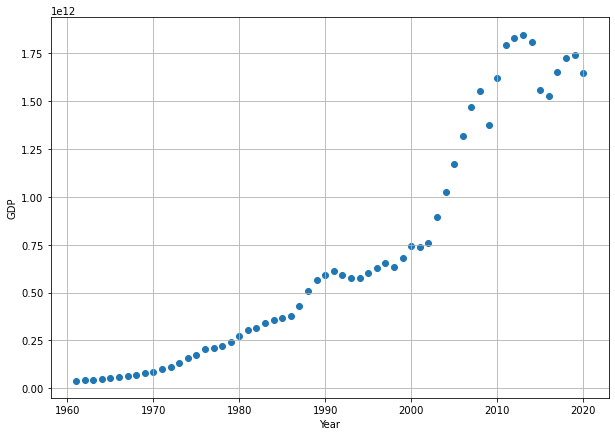

In [6]:
plt.figure(figsize=(10,7))
plt.scatter(pop_gdp.Year,pop_gdp.GDP)
plt.grid()
plt.xlabel('Year')
plt.ylabel('GDP')
plt.show()

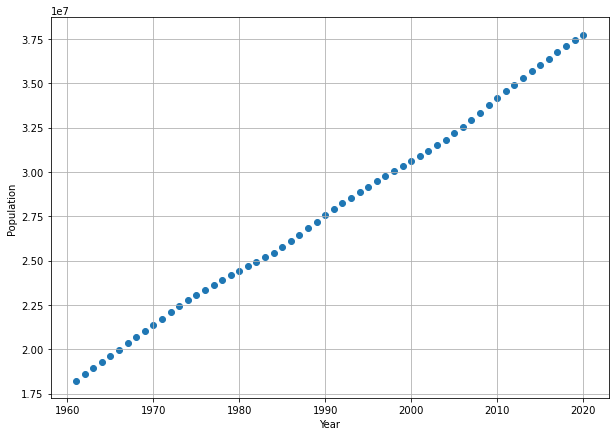

In [7]:
plt.figure(figsize=(10,7))
plt.scatter(pop_gdp.Year ,pop_gdp.Population)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()

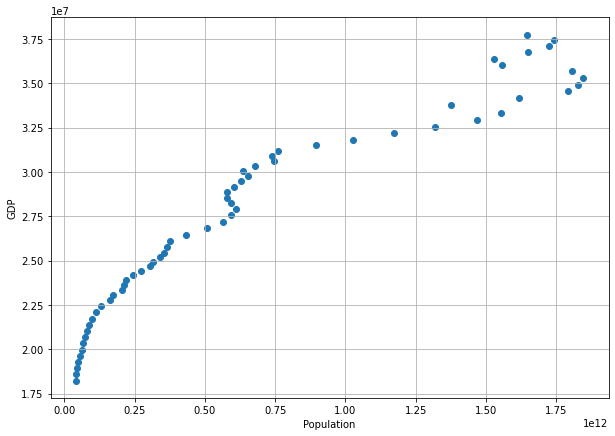

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(pop_gdp.GDP,pop_gdp.Population )
plt.grid()
plt.ylabel('GDP')
plt.xlabel('Population')
plt.show()

In [9]:
pop_gdp.corr()

,Year,GDP,Population
Year,1.000000,0.945201,0.999227
GDP,0.945201,1.000000,0.951043
Population,0.999227,0.951043,1.000000


#### Separating train data and test data

In [10]:
msk = np.random.rand(len(pop_gdp)) < 0.8
train = pop_gdp[msk]
test = pop_gdp[~msk]

In [11]:
Pop_y = np.asanyarray(train[['Population']])
GDP_X = np.asanyarray(train[['GDP']])

#### Train Data Normalization 

In [12]:
X_n =[]
for i in GDP_X :
    temp = ((i -  np.average(GDP_X))/(GDP_X.max() - GDP_X.min() ) )
    X_n = np.append(X_n,temp)

In [15]:
regr = linear_model.LinearRegression()
regr.fit(X_n.reshape(43,-1),Pop_y.reshape(43,-1)) # we have a problem here , 45 has been changeing , 45should be dynamic

print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[16203760.00287686]]
Intercept:  [27978422.13953488]


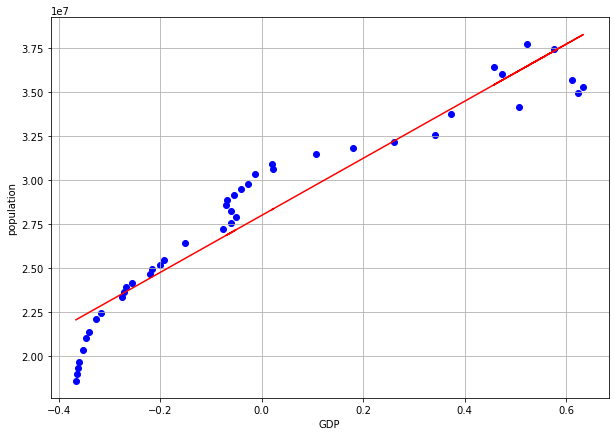

In [16]:
plt.figure(figsize=(10, 7))
plt.scatter(X_n, Pop_y,  color='blue')
plt.plot(X_n, regr.coef_[0][0]*X_n + regr.intercept_[0], '-r')
plt.xlabel("GDP")
plt.ylabel("population")
plt.grid()
plt.show()

In [17]:
Pop_y_t = np.asanyarray(test[['Population']])
GDP_X_t = np.asanyarray(test[['GDP']])

#### Test Data Normalization 

In [18]:
X_n_t =[]
for i in GDP_X_t :
    temp = ((i -  np.average(GDP_X_t))/(GDP_X_t.max() - GDP_X_t.min() ) )
    X_n_t = np.append(X_n_t,temp)

In [20]:
test_y_ = regr.predict(X_n_t.reshape(17,-1)) # we have a problem here , 10 has been changeing 

print("R2-score: %.2f" % r2_score(Pop_y_t , test_y_) )

R2-score: 0.89


#### trying new way to generate a model

In [21]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_n.reshape(43,-1)) # we have a problem here , 45 has been changeing 

In [22]:
regrp = linear_model.LinearRegression()
y_train_ = regrp.fit(X_poly, Pop_y.reshape(43,-1)) # we have a problem here , 45 has been changeing 

print ('Coefficients: ', regrp.coef_)
print ('Intercept: ',regrp.intercept_)

Coefficients:  [[        0.          20003853.35975745 -16744143.54832235]]
Intercept:  [29705062.84295737]


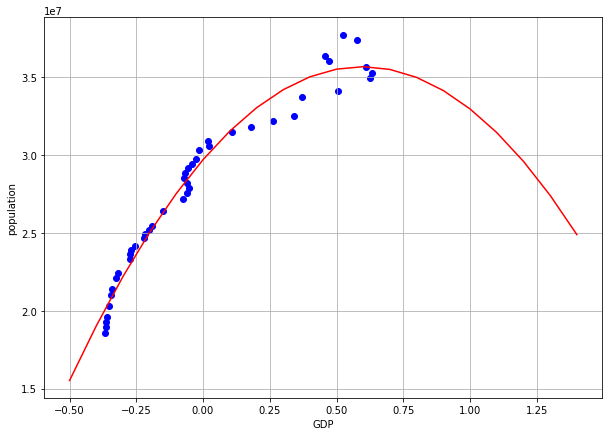

In [23]:
plt.figure(figsize=(10, 7))
plt.scatter(X_n, Pop_y,  color='blue')
XX = np.arange(-0.5 , 1.5 , 0.1)
yy = regrp.intercept_[0]+ regrp.coef_[0][1]*XX+ regrp.coef_[0][2]*np.power(XX, 2)
plt.plot(XX, yy, '-r' )
plt.grid()
plt.xlabel("GDP")
plt.ylabel("population")
plt.show()

In [25]:
X_poly_test = poly.fit_transform(X_n_t.reshape(17,-1)) # we have a problem here , 10 has been changeing 
test_y_p = regrp.predict(X_poly_test)

In [26]:
print("R2-score: %.2f" % r2_score(Pop_y_t,test_y_p ) )

R2-score: 0.96


##### model is not fit so we try sigmoid function.

In [ ]:
def sigmoid(x, a , b , c):
    y =(-(a*np.exp(-(b)*x)) + c)
    return y

In [ ]:
a =1
b =2
c =3
# I guessed this value with this  https://www.desmos.com/calculator/auubsajefh

Y_pred = sigmoid( X_n , a , b , c)

plt.plot(X_n, Y_pred)
plt.grid()

In [ ]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(sigmoid, X_n , n) # i have an error :)

print(" a = %f, b = %f c = %f"% (popt[0], popt[1] , popt[2]))

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_n, Pop_y,  color='blue')
plt.plot(X_n , sigmoid(X_n ,popt[0],popt[1] ,popt[2]) , color='red')
plt.grid()
plt.xlabel("GDP")
plt.ylabel("population")
plt.show()

In [ ]:
test_y_s = sigmoid(X_n_t ,popt[0],popt[1] ,popt[2])
print("R2-score: %.2f" % r2_score(Pop_y_t,test_y_s ) )

#### Let's test new data
Predicted Canada population for 2042 is 43948081  in https://ourworldindata.org/ 
<br>
and GDP in 2042 : 2433262 million US dollars  https://data.oecd.org/gdp/real-gdp-long-term-forecast.htm

In [ ]:
y = ((43948081 -  np.average(Pop_y))/(Pop_y.max() - Pop_y.min() ) )
    
x = ((243326200000 -  np.average(GDP_X))/(GDP_X.max() - GDP_X.min() ) )

print('normal x is %f and normal y is %f'% (x,y))

#### 1 - simple linear model

In [ ]:
print ("predicted y is :",regr.predict(x.reshape(1,-1)))

#### 2 - sigmoid function

In [ ]:
sigmoid(x ,popt[0],popt[1] ,popt[2])